## Data Preparation for the Models

In the data preparation step, main goal is to build an advanced pipeline to preprocess the data set and keep ready for the model

### 1. Import Dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from Scripts.custom_transformers import (
                                        TotalChargesCleaner,
                                        NewCustomerFlagger,
                                        TenureSegmenter,
                                        ServiceUsageClassifier,
                                        BillingLevelCreator,
                                        BillingTenureSegmenter,
                                        EngagementScorer,
                                        EngagementSegmenter,
                                        BillingEngageSegmenter,
                                        TenureEngageSegmenter,
                                        MonthToMonthFlagger,
                                        CoreProtectionFlagger,
                                        HighRiskFinancialProfileFlagger,
                                        OverallRiskScorer,
                                        KMeansClusterer,
                                        FeatureDropper
                                        )

warnings.filterwarnings('ignore')

### 2. Loading Data and Explore

In [2]:
df = pd.read_csv('../Data/Raw/Telco_Churn.csv')
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

### 3. Split the Data Set to Train-Test

In [4]:
df_cp = df.copy()

X = df_cp.drop(columns=['Churn'])
Y = df_cp['Churn']

X_train, X_test, Y_train, Y_test  = train_test_split(
                                                    X, Y, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                    )

### 3. Build Scikit-learn Pipelines

In [6]:
#Define the  final list of columns for the preprocessor step
numerical_features = ['tenure', 'MonthlyCharges', 'EngagementScore', 'OverallRiskScore', 'is_new_customer', 
                      'IsMonthToMonth', 'HasCoreProtection', 'HighRiskFinancialProfile'
                      ]

categorical_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 
                        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                        'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TenureSegment', 
                        'ServiceUsage', 'BillingLevel', 'BillingTenureSegment', 'EngagementSegment', 'BillingEngageSegment', 
                        'TenureEngageSegment', 'Cluster']

features_to_drop = ['customerID', 'TotalCharges']


# Define the final preprocessor ColumnTransformer
preprocessor = ColumnTransformer(
                                transformers=[
                                            ('num', StandardScaler(), numerical_features ),
                                            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
                                            ],
                                remainder='drop'
                                )

#Asssemble the full pipeline in the correct, logical order
full_pipeline = Pipeline(
                            steps=[
                            ('total_charges_cleaner', TotalChargesCleaner()),
                            ('new_customer_flagger', NewCustomerFlagger()),
                            ('tenure_segmenter', TenureSegmenter()),
                            ('service_usage_classifier', ServiceUsageClassifier()),
                            ('billing_level_creator', BillingLevelCreator()),
                            ('engagement_scorer', EngagementScorer()),
                            ('engagement_segmenter', EngagementSegmenter()),
                            ('core_protection_flagger', CoreProtectionFlagger()),
                            ('billing_tenure_segmenter', BillingTenureSegmenter()),
                            ('billing_engage_segmenter', BillingEngageSegmenter()),
                            ('tenure_engage_segmenter', TenureEngageSegmenter()),
                            ('month_to_month_flagger', MonthToMonthFlagger()),
                            ('high_risk_profile_flagger', HighRiskFinancialProfileFlagger()),
                            ('overall_risk_scorer', OverallRiskScorer()),
                            ('kmeans_clusterer', KMeansClusterer(n_clusters=4)),
                            # Feature Dropping
                            ('feature_dropper', FeatureDropper(columns_to_drop=features_to_drop)),
                            # Final Scaling and Encoding
                            ('final_preprocessor', preprocessor)
                                ]
                            )

print("Pipeline successfully created!")

print(full_pipeline)

Pipeline successfully created!
Pipeline(steps=[('total_charges_cleaner', TotalChargesCleaner()),
                ('new_customer_flagger', NewCustomerFlagger()),
                ('tenure_segmenter', TenureSegmenter()),
                ('service_usage_classifier', ServiceUsageClassifier()),
                ('billing_level_creator', BillingLevelCreator()),
                ('engagement_scorer', EngagementScorer()),
                ('engagement_segmenter', EngagementSegmenter()),
                ('core_prot...
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport

### 4. Apply all the Transformations to the raw data set using the pipeline

In [7]:



# Fit the pipeline using the training data
X_train_processed = full_pipeline.fit_transform(X_train)

#Transform test data with the fitted pipeline
X_test_processed = full_pipeline.transform(X_test)

In [8]:
# Save the entire fitted pipeline object to a file
joblib.dump(full_pipeline, '../Artifacts/preprocessing_pipeline.joblib')

print("Preprocessing pipeline saved successfully!")

Preprocessing pipeline saved successfully!


In [17]:
#===================== Converting numpy arrays to DataFrames ===================================
# Get the final preprocessor step from the fitted pipeline
final_preprocessor = full_pipeline.named_steps['final_preprocessor']

# Get the feature names from the preprocessor in the correct order
# This includes the scaled numerical names and the new one-hot encoded names
raw_feature_names = final_preprocessor.get_feature_names_out()

# Clean up the feature names to remove the 'num__' and 'cat__' prefixes
feature_names = [name.replace('num__', '').replace('cat__', '') for name in raw_feature_names]

# --- Create a DataFrame for the Processed Training Data ---
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)

print("--- Processed Training Data (as a DataFrame) ---")
display(X_train_processed_df.head())


# --- Create a DataFrame for the Processed Test Data ---
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)

print("\n--- Processed Test Data (as a DataFrame) ---")
display(X_test_processed_df.head())

--- Processed Training Data (as a DataFrame) ---


,tenure,MonthlyCharges,EngagementScore,OverallRiskScore,is_new_customer,IsMonthToMonth,HasCoreProtection,HighRiskFinancialProfile,gender_Female,gender_Male,...,TenureEngageSegment_Mid-HighEngage,TenureEngageSegment_Mid-LowEngage,TenureEngageSegment_Mid-MidEngage,TenureEngageSegment_New-HighEngage,TenureEngageSegment_New-LowEngage,TenureEngageSegment_New-MidEngage,Cluster_0,Cluster_1,Cluster_2,Cluster_3
0,-0.465683,-0.000474,0.363659,-1.825946,-0.042167,-1.099339,1.172267,-0.592246,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.885537,1.074754,0.794905,0.429728,-0.042167,-1.099339,-0.853048,-0.592246,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-1.284605,-1.376499,-1.361328,0.429728,-0.042167,0.909638,-0.853048,1.688488,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-1.161766,0.177346,-0.930081,1.181620,-0.042167,0.909638,-0.853048,1.688488,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,-1.325551,-0.098524,0.794905,-1.825946,23.714974,-1.099339,1.172267,-0.592246,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0



--- Processed Test Data (as a DataFrame) ---


,tenure,MonthlyCharges,EngagementScore,OverallRiskScore,is_new_customer,IsMonthToMonth,HasCoreProtection,HighRiskFinancialProfile,gender_Female,gender_Male,...,TenureEngageSegment_Mid-HighEngage,TenureEngageSegment_Mid-LowEngage,TenureEngageSegment_Mid-MidEngage,TenureEngageSegment_New-HighEngage,TenureEngageSegment_New-LowEngage,TenureEngageSegment_New-MidEngage,Cluster_0,Cluster_1,Cluster_2,Cluster_3
0,-1.284605,-1.331629,-1.361328,0.429728,-0.042167,0.909638,-0.853048,1.688488,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.353238,-1.316672,-0.930081,0.429728,-0.042167,0.909638,-0.853048,-0.592246,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.803645,-1.512772,-1.361328,-1.074054,-0.042167,-1.099339,-0.853048,-0.592246,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-1.284605,0.381756,-0.498835,1.181620,-0.042167,0.909638,-0.853048,1.688488,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.417836,-0.475768,-0.498835,-1.074054,-0.042167,-1.099339,1.172267,-0.592246,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### 5. Handle Class Imbalance

In [18]:
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_processed, Y_train)

print("\nOversampling complete.")
print(f"Shape of original training features: {X_train_processed.shape}")
print(f"Shape of resampled training features: {X_train_resampled.shape}")


Oversampling complete.
Shape of original training features: (5634, 84)
Shape of resampled training features: (8276, 84)


Text(0, 0.5, 'Count')

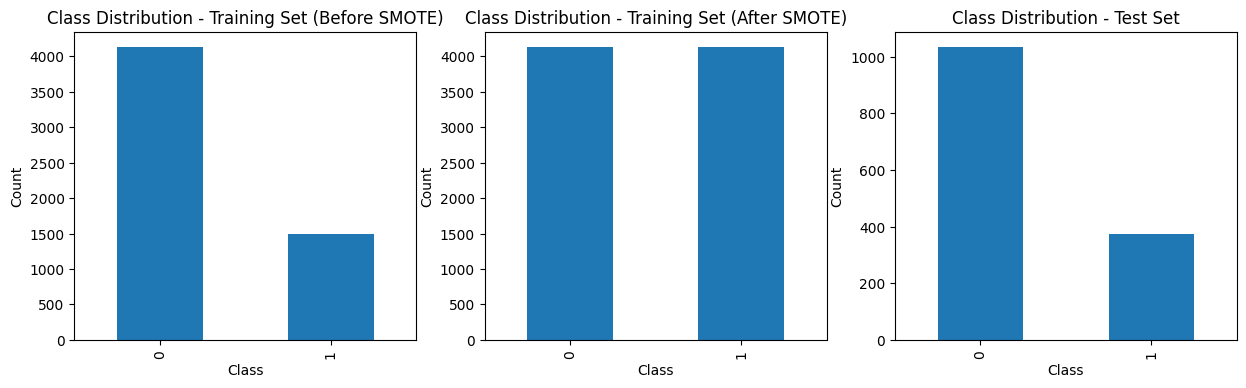

In [19]:
plt.figure(figsize=(15, 4))

# Before SMOTE
plt.subplot(131)
Y_train.value_counts().plot(kind='bar')
plt.title('Class Distribution - Training Set (Before SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')

# After SMOTE
plt.subplot(132)
Y_train_resampled.value_counts().plot(kind='bar')
plt.title('Class Distribution - Training Set (After SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')

# Test Set
plt.subplot(133)
Y_test.value_counts().plot(kind='bar')
plt.title('Class Distribution - Test Set')
plt.xlabel('Class')
plt.ylabel('Count')

### 6. Save the Data

In [20]:
#
np.savez('../Artifacts/X_train.npz', X_train_resampled)
np.savez('../Artifacts/Y_train.npz', Y_train_resampled)
np.savez('../Artifacts/X_test.npz', X_test_processed)
np.savez('../Artifacts/Y_test.npz', Y_test)